# Library Imports

In [1]:
import os
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Mount drive to load dataset from drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


# Function to load and preprocess images


In [3]:
data_dir = '/content/drive/My Drive/PRE_PROCESSED, ILUGBO'
desired_folders = {'1 - 3 Days': 0, '4 - 6 Days': 1, '7 - 9 Days': 2, '10 - 12 Days': 3, '13 - 15 Days': 4}

def load_images_from_desired_folders(data_dir, desired_folders):
    images = []
    labels = []
    for folder_name, label in desired_folders.items():
        folder_path = os.path.join(data_dir, folder_name)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
            labels.append(label)
    return images, labels

# Define constants

In [4]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32


In [ ]:
from keras.utils import to_categorical

# Load images and labels from desired folders
images, labels = load_images_from_desired_folders(data_dir, desired_folders)

# Convert labels to numerical values
NUM_CLASSES = len(desired_folders)  # Update NUM_CLASSES based on the number of desired folders
labels_numeric = np.array(labels)

# One-hot encode labels
labels_one_hot = to_categorical(labels_numeric, NUM_CLASSES)

# Split dataset and visualize distribution

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

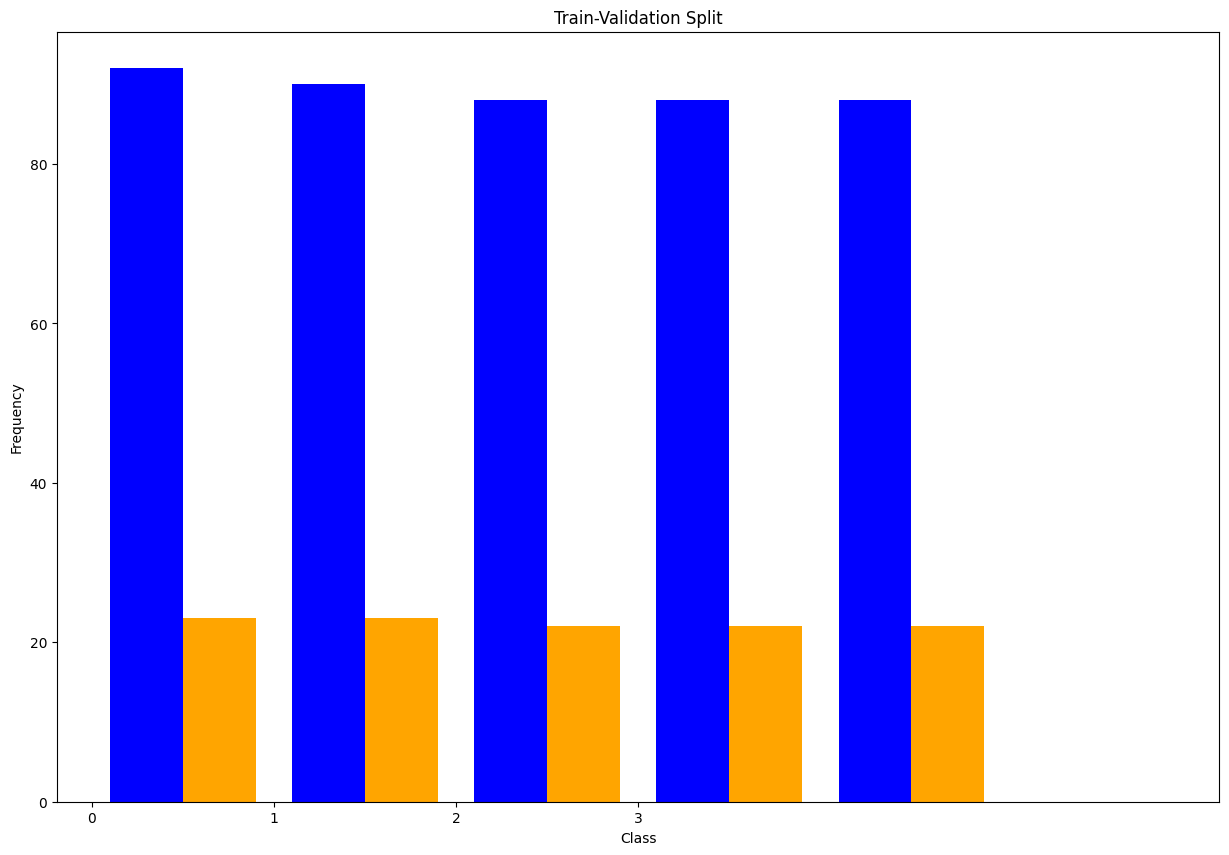

In [ ]:
# Convert to numpy arrays
images_np = np.array(images)

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images_np, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot)

train_images = train_images / 255.0
val_images = val_images / 255.0

# Visualize train-validation split
plt.figure(figsize=(15, 10))
plt.hist([np.argmax(train_labels, axis=1), np.argmax(val_labels, axis=1)], bins=range(7), color=['blue', 'orange'], label=['Train', 'Validation'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Train-Validation Split')
plt.xticks(range(5), ['1 - 3 Days',  '4 - 6 Days',  '7 - 9 Days',  '10 - 12 Days',  '13 - 15 Days'])
plt.legend()
plt.show()





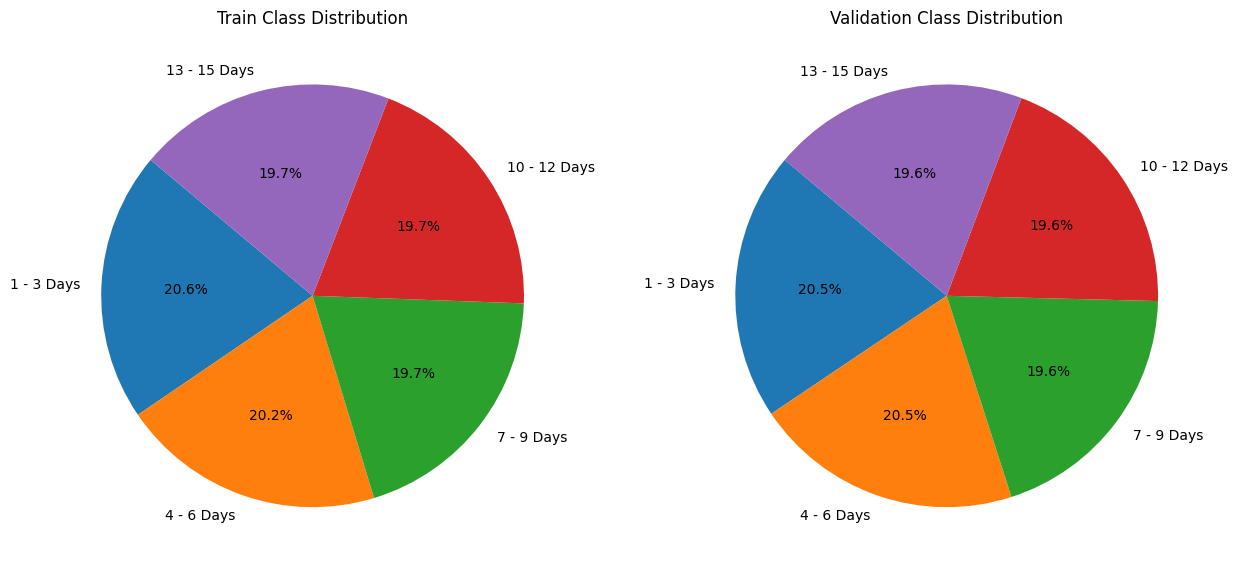

In [ ]:
# Define a dictionary to map numeric labels to class names
label_to_class = {0: '1 - 3 Days', 1: '4 - 6 Days', 2: '7 - 9 Days', 3: '10 - 12 Days', 4: '13 - 15 Days'}

# Class distribution of the images (pie chart)
train_class_distribution = np.sum(train_labels, axis=0)
val_class_distribution = np.sum(val_labels, axis=0)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.pie(train_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Train Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(val_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Validation Class Distribution')

plt.show()

# convolutional neural network

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256,256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(120, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(140, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(164, activation='relu'),
    Dense(5, activation='softmax')
])


# Model Training

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

# Define metrics callback
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_val, axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

        print(f'Epoch {epoch + 1} - Validation Metrics:')
        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')

# Define the filepath to save the best model
model_checkpoint_filepath = '/content/drive/My Drive/best_model_checkpoint.h5'

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=40,
    callbacks=[checkpoint, MetricsCallback((val_images, val_labels))]
)

Epoch 1/40
 6/14 [===========>..................] - ETA: 0s - loss: 4.5129 - accuracy: 0.2083

14/14 [==============================] - ETA: 0s - loss: 2.8784 - accuracy: 0.2175
Epoch 1: val_accuracy improved from -inf to 0.20536, saving model to /content/drive/My Drive/best_model_checkpoint.h5
4/4 [==============================] - 0s 34ms/step
Epoch 1 - Validation Metrics:
Precision: 0.0422 - Recall: 0.2054 - F1 Score: 0.0700
14/14 [==============================] - 13s 609ms/step - loss: 2.8784 - accuracy: 0.2175 - val_loss: 1.6288 - val_accuracy: 0.2054
Epoch 2/40
 1/14 [=>............................] - ETA: 1s - loss: 1.5908 - accuracy: 0.3438

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 1.5834 - accuracy: 0.2937
Epoch 2: val_accuracy improved from 0.20536 to 0.33929, saving model to /content/drive/My Drive/best_model_checkpoint.h5
4/4 [==============================] - 0s 32ms/step
Epoch 2 - Validation Metrics:
Precision: 0.3034 - Recall: 0.3393 - F1 Score: 0.2558
14/14 [==============================] - 3s 198ms/step - loss: 1.5834 - accuracy: 0.2937 - val_loss: 1.5216 - val_accuracy: 0.3393
Epoch 3/40
 1/14 [=>............................] - ETA: 1s - loss: 1.4861 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.3969
Epoch 3: val_accuracy improved from 0.33929 to 0.40179, saving model to /content/drive/My Drive/best_model_checkpoint.h5
4/4 [==============================] - 0s 32ms/step
Epoch 3 - Validation Metrics:
Precision: 0.3164 - Recall: 0.4018 - F1 Score: 0.3342
14/14 [==============================] - 3s 196ms/step - loss: 1.4074 - accuracy: 0.3969 - val_loss: 1.4693 - val_accuracy: 0.4018
Epoch 4/40
 1/14 [=>............................] - ETA: 1s - loss: 1.4271 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 1.2294 - accuracy: 0.4619
Epoch 4: val_accuracy improved from 0.40179 to 0.43750, saving model to /content/drive/My Drive/best_model_checkpoint.h5
4/4 [==============================] - 0s 32ms/step
Epoch 4 - Validation Metrics:
Precision: 0.4273 - Recall: 0.4375 - F1 Score: 0.3642
14/14 [==============================] - 3s 210ms/step - loss: 1.2294 - accuracy: 0.4619 - val_loss: 1.1245 - val_accuracy: 0.4375
Epoch 5/40
14/14 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.5561
Epoch 5: val_accuracy improved from 0.43750 to 0.55357, saving model to /content/drive/My Drive/best_model_checkpoint.h5
4/4 [==============================] - 0s 33ms/step
Epoch 5 - Validation Metrics:
Precision: 0.5571 - Recall: 0.5536 - F1 Score: 0.5460
14/14 [==============================] - 3s 206ms/step - loss: 1.0671 - accuracy: 0.5561 - val_loss: 1.0076 - val_accuracy: 0.5536
Epoch 6/40
14/14 [=============================

# Print out the metrics

In [ ]:
print('Accuracy:', 0.74107)
print('recall:', 0.7411)
print('F1 score:', 0.7335)
print('Precision:', 0.7345)


Accuracy: 0.74107
recall: 0.7411
F1 score: 0.7335
Precision: 0.7345


4/4 [==============================] - 0s 41ms/step
Sample 1: Actual class: 10 - 12 Days, Predicted class: 7 - 9 Days


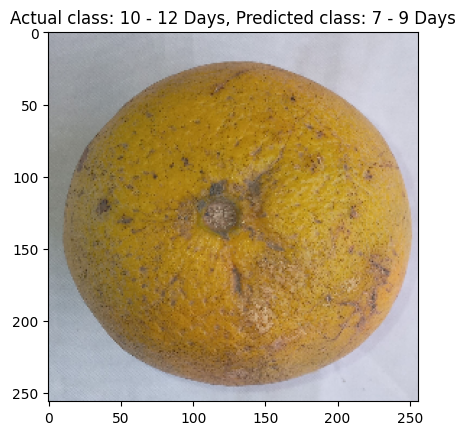

Sample 2: Actual class: 7 - 9 Days, Predicted class: 7 - 9 Days


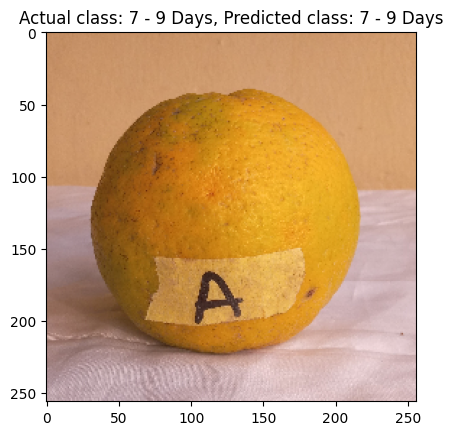

Sample 3: Actual class: 1 - 3 Days, Predicted class: 1 - 3 Days


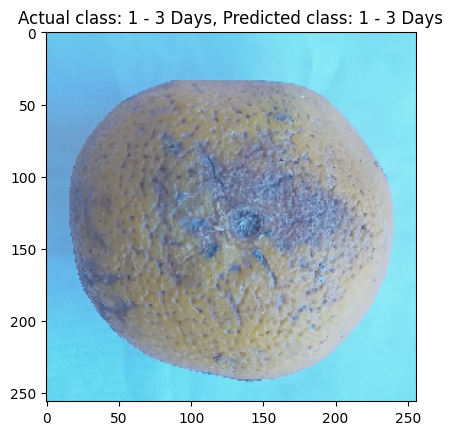

Sample 4: Actual class: 1 - 3 Days, Predicted class: 1 - 3 Days


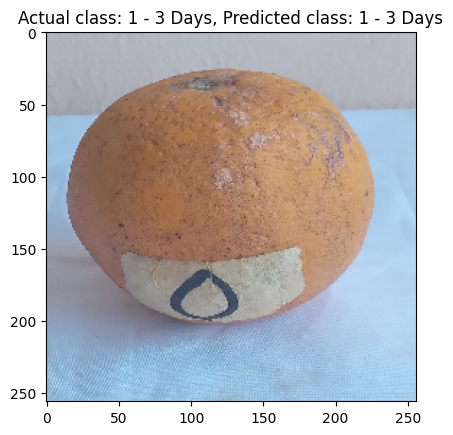

In [ ]:
# Predictions
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images and predictions
for i in range(4):
    plt.imshow(val_images[i])

    # Map numeric label to actual class name
    actual_class_name = label_to_class[np.argmax(val_labels[i])]
    predicted_class_name = label_to_class[predicted_classes[i]]

    print(f"Sample {i+1}: Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")

    plt.title(f"Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")
    plt.show()

# Evaluation on test set

In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')